# Hourly climate projections bias-corrected to the location of a weather station

**Intended Application**: As a user, I want to **<span style="color:#FF0000">generate annual hourly profiles of localized data, or an 8760</span>** by:
1. Accessing and exporting hourly data at station locations (netCDF or csv)
2. Examine the “8760’s” and find the one with the smallest distance from the median.

**Runtime**: With the default settings, this notebook takes approximately **6 minutes** to run from start to finish. Modifications to selections may increase the runtime.

### Step 0: Import libaries
First, import our python package and any other necessary libraries for analysis. 

In [1]:
import climakitae as ck
import climakitaegui as ckg
import panel as pn
pn.extension()

import numpy as np
import xarray as xr
import pandas as pd
from copy import deepcopy

### Step 1: Access
#### 1a) Select data of interest
For the rest of the examples in this notebook, you will want to select `station` for `Data type`. Make any other choices that fit your needs. For the default, we recommend starting with a single station selection.

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


Row
    [0] Card(collapsible=False, styles={'header_background': 'lig...}, title='Data Options i..., width=600)
        [0] Column
            [0] Row
                [0] Column(width=200)
                    [0] StaticText(name='Data Type')
                    [1] RadioBoxGroup(options=OrderedDict({'Gridded': 'G...]), value='Gridded')
                [1] Column(width=200)
                    [0] StaticText(name='Approach')
                    [1] RadioBoxGroup(options=OrderedDict({'Time': 'Time...]), value='Time')
                [2] Column(width=200)
                    [0] StaticText(name='Downscaling Method')
                    [1] RadioBoxGroup(name='Downscaling method', options=OrderedDict({'Dynamical': ...]), value='Dynamical')
        [1] Divider(margin=(-10, 0, 0, 0))
        [2] Row
            [0] Column(width=300)
                [0] StaticText(name='Variable Type')
                [1] RadioBoxGroup(inline=True, options=OrderedDict({'Variable': '...]), value='Variable')
                [2] Select(options=OrderedDict({'Air Temperat...]), value='Air Temperature at 2m', width=225)
                [3] StaticText(value="Temperature o...)
            [1] Column
                [0] Row
                    [0] Column(width=100)
                        [0] StaticText(name='Variable Units')
                        [1] RadioBoxGroup(name='Units', options=OrderedDict({'K': 'K', ...]), value='K')
                    [1] Column(width=100)
                        [0] StaticText(name='Timescale')
                        [1] RadioBoxGroup(options=OrderedDict({'daily': 'dai...]), value='monthly')
                    [2] Column(width=100)
                        [0] StaticText(name='Model Grid-Spacing')
                        [1] RadioBoxGroup(name='Resolution', options=OrderedDict({'3 km': '3 km...]), value='9 km')
                [1] Column(width=300)
                    [0] StaticText(styles={'color': 'red'})
        [3] Divider(margin=(-10, 0, 0, 0))
        [4] Column
            [0] StaticText(name='WARMING LEVELS APPROACH', value='Options only v...)
            [1] Row
                [0] Column(width=270)
                    [0] StaticText(name='Years around G..., value='e.g. 15 means a...)
                    [1] IntSlider(end=25, start=5, value=15, width=240)
                [1] Column(width=250)
                    [0] StaticText(name='Warming Level (°C)')
                    [1] CheckBoxGroup(inline=True, options=OrderedDict({'n/a': '...]), value=['n/a'])
        [5] Divider(margin=(-10, 0, 0, 0))
        [6] Column
            [0] StaticText(name='TIME-BASED APPROACH', value='Options only v...)
            [1] Row
                [0] Column(width=300)
                    [0] StaticText(name='Years', value='How do you want t...)
                    [1] RangeSlider(end=2100, start=1950, step=1, value=(1980, 2015), value_end=2015, value_start=1980, width=250)
                    [2] StaticText(name='Historical Data', value='<br>Estimates o...)
                    [3] CheckBoxGroup(name='Scenario historical', options=OrderedDict({'Historical C...]), value=['Historical Climate'])
                    [4] StaticText(name='Future Model Data', value='<br> Shared S...)
                    [5] CheckBoxGroup(name='Scenario ssp', options=OrderedDict({'SSP 2-4.5': ...]))
                [1] Column(width=300)
                    [0] ParamMethod(method, _pane=Matplotlib, defer_load=False)
                    [1] StaticText(styles={'color': 'red'})
    [1] Card(collapsible=False, height=670, sizing_mode='fixed', styles={'header_background': 'lig...}, title='Location Options f..., width=635)
        [0] Row
            [0] Column(width=280)
                [0] ParamMethod(method, _pane=Matplotlib, defer_load=False)
                [1] Select(name='Subset the data by...', options=OrderedDict({'none': 'none...]), value='none', width=225)
                [2] MultiSelect(name='Location selection', options=OrderedDict({'entire d...]), value=
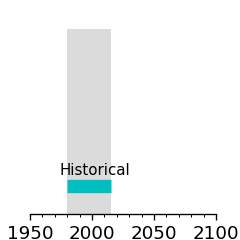
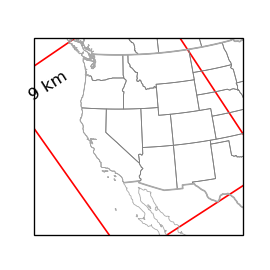

In [2]:
selections = ckg.Select()
selections.show()

#### 1b) Now retrieve the data, storing it in a variable called 'data'
The data that will be retrieved is being bias-corrected using hourly historical observations at each station selected. The historical observations come from [HadISD](https://catalogue.ceda.ac.uk/uuid/f579035b3c954475922e4b13705a7669). 

The bias-correction procedure happening behind-the-scenes is called Quantile Delta Mapping ([QDM](https://journals.ametsoc.org/view/journals/clim/28/17/jcli-d-14-00754.1.xml)), which is designed to preserve trends while allowing for different biases across quantiles. For more information, `localization_methodology.ipynb` steps through the bias-correction procedure in more detail. 

You will see a warning regarding "non-standard calendar" -- don't worry about this! This just means that the data specifically had leap days removed in order to downscale. Removing leap days in bias correction is the standard best practice for consistency.

In [3]:
%%time
data = selections.retrieve()

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
! Returned data array is large. Operations could take up to 5x longer than 1GB of data!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

CPU times: user 1.85 s, sys: 216 ms, total: 2.07 s
Wall time: 4.57 s


#### 1c) At this point you may wish to load the data 
Then you can examine it further, and save time later when you go to export it. When you explicitly load the data, only then does it actually perform all of the computations to bias-correct the gridded data to your chosen stations. If you skip this step it will defer this computation until you do some other step that *uses* the data, whether that is to graph it or export it. 

Depending on the number of stations you selected above, the time that this step takes to complete will scale linearly with the number of stations selected.

In [4]:
%%time
data = ck.load(data)

Processing data to read 996.09 MB of data into memory... Complete!
CPU times: user 2.19 s, sys: 1.6 s, total: 3.79 s
Wall time: 3.9 s


A quick preview of the data structure can be seen by executing a cell with the data variable as the final line.

In [ ]:
data

Now that we have hourly data to work with, we can create and sample from a pool of 8760's which have consistent and realistic time series properties, improving on stochastic sampling methods that had otherwise been in use.

### Step 2: Sample the "8760" closest to the median

#### 2a) Calculate 8760s

One way that you may wish to use this data is to examine "8760's", or entire years of hourly data. If you chose a wide range of years previously, you might want to now sub-select, for example, only a historical reference period.

Two main reasons to choose only a historical period:
- the following steps do not correct for the trends in the data due to climate change, so the median will reflect when the median amount of climate change has happened, instead of a median year solely with respect to year-to-year variability
- if you max out on the number of years, subsequent steps may execute more slowly

In [ ]:
data = data.sel(time=slice('19810101','20101231'))

Beware that if you selected `Historical Climate`, and don't do something like the step above you will have partial years at the beginning and end, since the simulations start in Sept and run through Aug of the following calendar year. You could alternatively deal with that this way:

How many 8760s are there in this dataset for each station location?

In [ ]:
number_of_years = (data['time.year'].max() - data['time.year'].min()).values
unique_8760s = number_of_years * len(data.simulation) 
unique_8760s

For each station, let's find the "8760" that is closest to the median (the euclidean distance between that year and the median across all days and hours is smallest).

Next, we'll prepare some helper functions. You could also loop over days and times, but that would take much longer to execute.

In [ ]:
def get_difference_hour(y): 
    #for this hour, of this day of the year, the median across all 8760s:
    median = y.quantile(q=0.5)
    #return the difference from that median for each 8760:
    return np.abs(y - median)

def get_difference(y): 
    return y.groupby('time.hour').apply(get_difference_hour) 
        
def euclidean_distance(y):
    return xr.DataArray(np.sqrt(np.sum(y**2)))
    
def get_distance(y):
    return y.groupby('simulation').apply(euclidean_distance)

def get_median_8760(y):
    difference_from_median = y.squeeze().groupby('time.dayofyear').apply(get_difference) 
    euclidean_distance = difference_from_median.groupby('time.year').apply(get_distance)
    final = euclidean_distance.stack(all8760s=['year','simulation'])
    which_8760 = final.isel(all8760s=final.argmin())
    to_return = y.sel(time=str(which_8760.year.values),simulation=which_8760.simulation.values)
    # set time to the same generic calendar year regardless:
    to_return['time'] = np.arange(1,8761)
    # drop the simulation coord 
    to_return = to_return.drop("simulation")
    return to_return

Note that you could replace the 0.5 quantile (or median) with some other quantile.

Apply the above functions across all the stations in the dataset:

In [ ]:
median_year = data.squeeze().map(get_median_8760)

It doesn't matter *which* year this is in one of the simulations, because the phasing and timing of interannual variability is random, and not meant to match how this actually unfolded historically (unless you've selected "Historical Reconstruction").

Now we can see what that year looks like as a time-series.

In [ ]:
median_year.drop(['scenario']).hvplot()

#### 2b) Compare with other 8760s

We will compare this 8760 (closest to the median) with the statistical median itself, and the range of other 8760s, looking one station at a time. You'll see that we set the time dimension to a length of 8784 - this is to accommodate leap days, but don't worry, they are dropped in according to scientific best practices for bias-correction. 

First, a little work gathering and reshaping the data to plot:

In [ ]:
def median_by_hour(y):
    by_hour = y.groupby('time.hour').quantile(q=0.5)
    generic_year_day = pd.to_datetime('1981'+str(y['time.month'].values[0]).zfill(2)+
                                      str(y['time.day'].values[0]).zfill(2))
    by_hour['time'] = pd.date_range(generic_year_day,periods=24,freq='H')
    by_hour = by_hour.drop('hour')
    return by_hour

stat_median = data.groupby('time.dayofyear').apply(median_by_hour)
stat_median['time'] = np.arange(1,8785) # handle for leap days (8760 + 24)
stat_median = stat_median.to_array('station')

In [ ]:
median_year_by_station = median_year.to_array('station')

Some rearrangement of the initial data, by year:

In [ ]:
all8760s = data.to_array('station')

def number_years(y):
    y['year'] = y['time.year'].values[0]
    y['time'] = np.arange(1,8761)
    return y

all8760s = all8760s.groupby('time.year').apply(number_years)

Now finally plot it all together. (Note that this plot is interactive and you can zoom in and out.) Initial plotting (and each time you switch station) may take a moment.

Samples from all 8760's are plotted in light grey, the statistical medians for each of the 8760 hours of the year are in black, and the single 8760 with the smallest euclidean distance from that statistical median is shown on top in the thin line.

In [ ]:
all8760s.hvplot(x='time', groupby='station', kind='scatter', color='grey', alpha=0.2) * \
    stat_median.hvplot(groupby='station', kind='scatter', c='k') * \
    median_year_by_station.hvplot(groupby='station', kind='line', line_width=0.5)

#### 2c) Typical year heatmap
Turning back to that closest-to-the-median year, with all of its variability, let's view it another way.

You may want to rearrange the timeseries to view as a heatmap over day-of-year vs hour-of-day. There may be other ways to do this, but here we will add dimensions for day and hour, and then convert into a pandas dataframe, which we can more easily pivot.

In [ ]:
median_year_array = deepcopy(median_year)
median_year_array['time'] = pd.date_range('19810101',periods=8760,freq='H')
median_year_array['hour'] = median_year_array['time.hour']
median_year_array['dayofyear'] = median_year_array['time.dayofyear']

median_year_df = median_year_array.to_pandas().drop(['scenario'],axis=1) 
median_year_df = median_year_df.pivot(index="dayofyear", columns="hour")
median_year_df.columns.names = ['station', 'hour']

Then put it back into an xarray datastructure again for better plotting of heatmaps, and examine the new data structure.

In [ ]:
median_year_array = median_year_df.unstack().to_xarray()

With just a little attention to formatting in local time.

In [ ]:
def to_PST(hour):
    #take hour 0-23, assumed UTC
    #return formatted Pacific Standard Time string
    return pd.to_datetime(hour*60, origin=pd.Timestamp('1981-01-01'),unit='m', utc=True).tz_convert('US/Pacific').strftime('%r')

Finally, the heatmap:

In [ ]:
median_year_array.hvplot(
    x='dayofyear',
    y='hour',
    yticks=[(int(one_hour),to_PST(one_hour)) for one_hour in median_year_array.hour.values],
    groupby='station',
    cmap='Reds',
    clabel=selections.variable +' ('+ selections.units +')',
)

### Step 3: Export the data
We'll show exporting of the data as originally accessed, but you could also export the processed data in a similar fashion.
#### 3a) Option 1: netCDF
The simplest way to export the data is to use the netCDF format, which this data structure already mirrors in memory.

In [ ]:
data.to_netcdf('test_output.nc')

The file should appear in the file list to the left, after the cell is done executing $[*]$.

For reference, to read this back in using python:

In [ ]:
data_back = xr.open_dataset('test_output.nc')
data_back

#### 3b) Option 2: csv
If for some reason you prefer a .csv file, first convert the data structure to a table compatible with export to csv.

In [ ]:
data_table = data.to_dataframe(dim_order=['scenario','simulation','time'])
data_table

You can save the above out to csv to work with in R, but it will be too many rows for e.g. Excel to read in.

Before saving out the csv, you may want to first remove any spaces in the column headers.

In [ ]:
data_table_for_R = data_table
data_table_for_R.columns = data_table_for_R.columns.str.replace(' ', '_')

We can also rearrange the data so it's distributed over more columns instead, although it may take a moment.

In [ ]:
data_table = data_table.unstack().unstack().stack('time')

Examine it first to make sure you like the arrangement.

In [ ]:
data_table

And export is a simple matter. As above, this file will appear in the file list to the left when the cell is done executing $[*]$.

In [ ]:
data_table.to_csv('test_output.csv')

Or if you wanted the R-friendly version:

In [ ]:
data_table_for_R.to_csv('test_output_for_R.csv')

For reference, here would be how to read this back in using python:

In [ ]:
table_back = pd.read_csv('test_output.csv',index_col=[0,1], header=[0,1])
table_back